In [1]:
import numpy as np
import torch
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn
import sys
seaborn.set()

import warnings
warnings.filterwarnings("ignore")

import reservoir
import computekernel
from reckernel import RecKernel
from kuramoto import KS
%load_ext autoreload
%autoreload 2
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Kuramoto data generation and kernel test

In [196]:
L    = 22 / (2 * np.pi)
N    = 100
dt   = 0.25
ninittransients = 1000
tend = 5000 + ninittransients*dt  #50000
dns  = KS(L=L, N=N, dt=dt, tend=tend)

N_data_train = 10000
N_data_test = 10000

dns.simulate()
u = dns.uu[ninittransients:] / np.sqrt(N)
[u_train, u_test, _] = np.split(u, [N_data_train, N_data_train+N_data_test], axis=0)

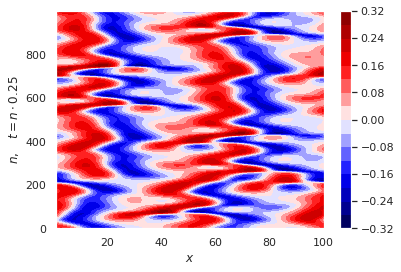

In [197]:
N_plot = 1000
u_plot = u[:N_plot,:]
N_plot = np.shape(u_plot)[0]
# Plotting the contour plot
fig = plt.subplots()
# t, s = np.meshgrid(np.arange(N_plot)*dt, np.array(range(N))+1)
n, s = np.meshgrid(np.arange(N_plot), np.array(range(N))+1)
plt.contourf(s, n, np.transpose(u_plot), 15, cmap=plt.get_cmap("seismic"))
plt.colorbar()
plt.xlabel(r"$x$")
plt.ylabel(r"$n, \quad t=n \cdot {:}$".format(dt));

#     plt.savefig(base_path + "/Figures/Plot_U_first_N{:d}.png".format(N_plot), bbox_inches="tight")
#     plt.close()

In [198]:
def gaussian_data(n_input, input_len_max, input_dim, fix_seed=False):
    if fix_seed == True:
        torch.manual_seed(42)
    return torch.randn(n_input, input_len_max, input_dim).to(device) / np.sqrt(input_dim)

# Single recursive prediction (RC)

In [228]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon_range = 1
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

n_res = 1000
input_scale = 0.1
res_scale = 0.7
leak_rate = 0.3

initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf', leak_rate=leak_rate)
X = model.forward(u_train_t, initial_state=initial_state).to(device)

output_w = model.train(X, out_train, alpha=1e-3)
pred_output = X @ output_w

Xtest = model.forward(u_test_t, initial_state=initial_state).to(device)
pred_output_test = Xtest @ output_w

n_rec_pred = 2000
Xtest = Xtest[:n_rec_pred, :]

input_dim = 100
n_rec = 200
test_rec_pred = model.rec_pred(Xtest, output_w, n_rec, input_dim)
print(test_rec_pred.shape)

torch.Size([2000, 20100])


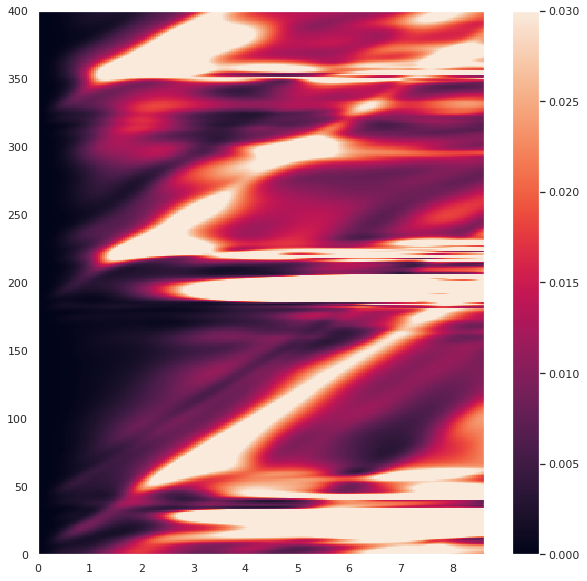

In [229]:
new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(input_len, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)

rec_pred = test_rec_pred.reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
truth = out_test[:n_rec_pred, :].reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
diff = rec_pred - truth
test = torch.mean(diff**2, dim=2)[100:500, :]
plt.figure(figsize=(10,10))
plt.imshow(test.cpu(), aspect='auto', vmin=0, vmax=0.03, extent=[0, 200*0.043, 0, 400])
plt.grid(b=None)
plt.colorbar()

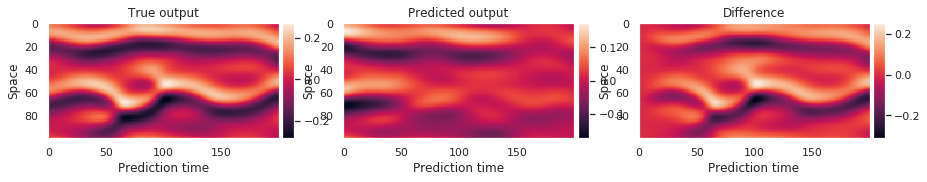

In [221]:
origin = 400
pred_plot = test_rec_pred[origin, :].reshape((n_rec+1)*pred_horizon_range, input_dim)

new_pred_horizon = pred_horizon_range * (n_rec+1)
out_test = torch.zeros(input_len, input_dim * new_pred_horizon).to(device)
for pred_horizon in range(1, new_pred_horizon+1):
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)

true_plot = out_test[origin, :].reshape(-1, input_dim).cpu()

from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(true_plot.T)
axes[0].grid(b=None)
axes[0].set_xlabel("Prediction time")
axes[0].set_ylabel("Space")
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(pred_plot.T)
axes[1].grid(b=None)
axes[1].set_xlabel("Prediction time")
axes[1].set_ylabel("Space")
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

plot = axes[2].imshow(((true_plot-pred_plot)).T)
axes[2].grid(b=None)
axes[2].set_xlabel("Prediction time")
axes[2].set_ylabel("Space")
axes[2].set_title("Difference");
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax);

# Grid search on hyperparameters

In [ ]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon_range = 1
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

n_res = 1000
input_scale_vec = np.arange(start=0.02, stop=1, step=0.02)
res_scale_vec = np.arange(start=0.05, stop=2, step=0.05)
leak_rate_vec = np.arange(start=0.05, stop=1, step=0.05)
err = torch.zeros(len(input_scale_vec), len(res_scale_vec), len(leak_rate_vec))

for i, input_scale in tqdm(enumerate(input_scale_vec)):
    for j, res_scale in enumerate(res_scale_vec):
        for k, leak_rate in enumerate(leak_rate_vec):

            initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
            model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                                  f='erf', leak_rate=leak_rate)
            X = model.forward(u_train_t, initial_state=initial_state).to(device)

            output_w = model.train(X, out_train, alpha=1e-3)
            pred_output = X @ output_w

            Xtest = model.forward(u_test_t, initial_state=initial_state).to(device)
            pred_output_test = Xtest @ output_w

            n_rec_pred = 2000
            Xtest = Xtest[:n_rec_pred, :]

            input_dim = 100
            n_rec = 200
            test_rec_pred = model.rec_pred(Xtest, output_w, n_rec, input_dim)

            new_pred_horizon = pred_horizon_range * (n_rec+1)
            out_test = torch.zeros(input_len, input_dim * new_pred_horizon).to(device)
            for pred_horizon in range(1, new_pred_horizon+1):
                out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)

            rec_pred = test_rec_pred.reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
            truth = out_test[:n_rec_pred, :].reshape(n_rec_pred, (n_rec+1)*pred_horizon_range, input_dim).to(device)
            diff = rec_pred - truth
            mse = torch.mean(diff**2, dim=2)[100:, :] # remove the first points to removce initialization artefacts
            err[i, j, k] = torch.mean(mse)

0it [00:00, ?it/s]

In [ ]:
np.save('out/200522_ks_rc_recpred_gridsearch', err)

In [ ]:
print('Finished')

# Prediction on Kuramoto (SRC)

In [59]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon_range = 100
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
out_test = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_test_t, -pred_horizon, dims=0)

n_curves = 3
n_res_range = np.logspace(2, 4, num=n_curves, dtype=int)
input_scale = 0.1
res_scale = 0.7

mse = torch.zeros(n_curves, pred_horizon_range)

for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='erf', random_projection='structured')
    X = model.forward(u_train_t, initial_state=initial_state).to(device)

    output_w = model.train(X, out_train)
    pred_output = X @ output_w

    Xtest = model.forward(u_test_t, initial_state=initial_state).to(device)
    pred_output_test = Xtest @ output_w

    for pred_horizon in range(1, pred_horizon_range+1):
        mse[i, pred_horizon-1] = torch.mean(
            (pred_output_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] 
            - out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim])**2)

3it [00:20,  6.95s/it]


In [62]:
print(pred_output_test.shape)

torch.Size([10000, 10000])


In [63]:
print(out_test.shape)

torch.Size([10000, 10000])


In [65]:
origin = 1000
out_plot = torch.zeros(pred_horizon_range, input_dim)
pred_plot = torch.zeros(pred_horizon_range, input_dim)

for pred_horizon in range(pred_horizon_range):
    out_plot[pred_horizon, :] = out_test[origin, pred_horizon*input_dim:(pred_horizon+1)*input_dim]
    pred_plot[pred_horizon, :] = pred_output_test[origin, pred_horizon*input_dim:(pred_horizon+1)*input_dim]

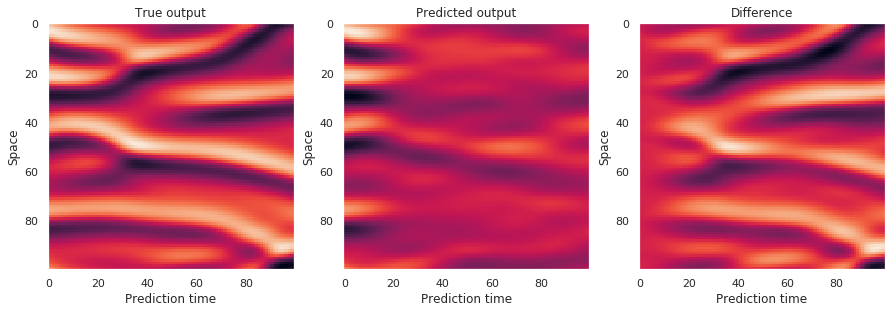

In [72]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(out_plot.T)
# axes[0].axis("off")
axes[0].grid(b=None)
axes[0].set_xlabel("Prediction time")
axes[0].set_ylabel("Space")
axes[0].set_title("True output")
# divider = make_axes_locatable(axes[0])
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(pred_plot.T)
# axes[1].axis("off")
axes[1].grid(b=None)
axes[1].set_xlabel("Prediction time")
axes[1].set_ylabel("Space")
axes[1].set_title("Predicted output")
# divider = make_axes_locatable(axes[1])
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(plot, cax=cax)

plot = axes[2].imshow((out_plot-pred_plot).T)
# axes[2].axis("off")
axes[2].grid(b=None)
axes[2].set_xlabel("Prediction time")
axes[2].set_ylabel("Space")
axes[2].set_title("Difference");
# divider = make_axes_locatable(axes[2])
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(plot, cax=cax);

In [78]:
np.save('out/200522_out_test_src', out_test.cpu())
np.save('out/200522_pred_out_src', pred_output_test.cpu())

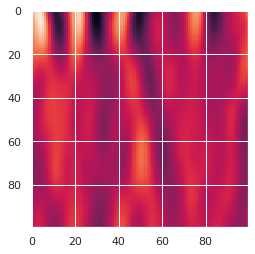

In [67]:
plt.imshow(pred_plot)

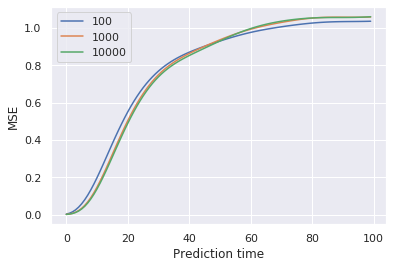

In [82]:
sampl = 1
renorm = torch.mean(out_test**2)
plt.plot(mse[::sampl, :].T / renorm)
plt.xlabel('Prediction time')
plt.ylabel('MSE')
plt.legend(n_res_range[::sampl]);

In [61]:
np.save('out/200522_ksmse_src_pred100_nres10p2to10p4_in01res07', mse)

# Grid search for SRC

In [120]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
pred_horizon = 10
out_train = torch.roll(u_train_t, -pred_horizon, dims=0)
out_test = torch.roll(u_test_t, -pred_horizon, dims=0)

n_res = 1000
initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
n_input = 1 # number of time series
input_len, input_dim = u_train_t.shape # time steps t

input_scale_vec = np.arange(start=0.05, stop=0.5, step=0.05)
res_scale_vec = np.arange(start=0.2, stop=2, step=0.2)
leak_rate_vec = np.arange(start=0.1, stop=1, step=0.1)
err = torch.zeros(len(input_scale_vec), len(res_scale_vec), len(leak_rate_vec))

for i, input_scale in tqdm(enumerate(input_scale_vec)):
    for j, res_scale in enumerate(res_scale_vec):
        for k, leak_rate in (enumerate(leak_rate_vec)):
            model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                                  f='erf', random_projection='structured', leak_rate=leak_rate)
            X = model.forward(u_train_t, initial_state=initial_state).to(device)

            output_w = model.train(X, out_train)
            pred_output = X @ output_w

            Xtest = model.forward(u_test_t, initial_state=initial_state).to(device)
            pred_output_test = Xtest @ output_w

            err[i, j, k] = torch.norm(pred_output_test - out_test)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:06,  6.73s/it]
2it [00:13,  6.71s/it]
3it [00:20,  6.69s/it]
4it [00:26,  6.68s/it]
5it [00:33,  6.66s/it]
6it [00:39,  6.66s/it]
7it [00:46,  6.66s/it]
8it [00:53,  6.66s/it]
9it [00:59,  6.66s/it]

0it [00:00, ?it/s]
1it [00:06,  6.65s/it]
2it [00:13,  6.65s/it]
3it [00:19,  6.65s/it]
4it [00:26,  6.65s/it]
5it [00:33,  6.66s/it]
6it [00:39,  6.66s/it]
7it [00:46,  6.66s/it]
8it [00:53,  6.66s/it]
9it [00:59,  6.66s/it]

0it [00:00, ?it/s]
1it [00:06,  6.66s/it]
2it [00:13,  6.66s/it]
3it [00:19,  6.66s/it]
4it [00:26,  6.66s/it]
5it [00:33,  6.66s/it]
6it [00:39,  6.66s/it]
7it [00:46,  6.66s/it]
8it [00:53,  6.66s/it]
9it [00:59,  6.66s/it]

0it [00:00, ?it/s]
1it [00:06,  6.68s/it]
2it [00:13,  6.67s/it]
3it [00:20,  6.67s/it]
4it [00:26,  6.67s/it]
5it [00:33,  6.67s/it]
6it [00:40,  6.67s/it]
7it [00:46,  6.68s/it]
8it [00:53,  6.67s/it]
9it [01:00,  6.69s/it]

0it [00:00, ?it/s]
1it [00:06,  6.76s/it]
2it [00:13,  6.72s/it]
3it [00:

In [115]:
err

tensor([[83.6759, 80.9919, 78.6899, 76.5551, 75.3789, 74.5852, 74.6645, 77.3397,
         90.2998],
        [72.5666, 67.7859, 66.0270, 63.8800, 62.3449, 61.2913, 60.8656, 62.3853,
         70.2558],
        [69.0353, 61.8127, 59.7926, 58.1848, 56.3734, 55.3376, 54.8119, 55.9274,
         61.8167],
        [68.1425, 59.1553, 56.1434, 54.8072, 53.1576, 51.8481, 51.3309, 52.2446,
         57.2819],
        [68.1086, 58.3159, 54.0685, 52.4963, 51.1817, 49.6376, 49.0471, 49.7842,
         54.3274],
        [68.2898, 58.4553, 53.0737, 50.9136, 49.7700, 48.2403, 47.4243, 48.0759,
         52.4250],
        [68.4772, 59.0738, 52.8226, 49.9133, 48.6825, 47.3246, 46.2447, 46.8334,
         51.0946],
        [68.6162, 59.8851, 53.0672, 49.3861, 47.8509, 46.6672, 45.4077, 45.8902,
         50.1374],
        [68.7023, 60.7342, 53.6256, 49.2358, 47.2521, 46.1491, 44.8318, 45.1692,
         49.4125]])

In [116]:
torch.norm(pred_output_test)

tensor(121.7376, device='cuda:0')

In [121]:
print(np.min(err.numpy()))

44.68186


In [124]:
mini = np.argmin(err.numpy())
x = mini // (err.shape[1]*err.shape[2])
rem = np.mod(mini, err.shape[1]*err.shape[2])
y = rem // err.shape[2]
z = np.mod(rem, err.shape[2])
print(x,y,z)
print(f'input_scale {input_scale_vec[x]}')
print(f'res_scale {res_scale_vec[y]}')
print(f'leak_rate {leak_rate_vec[z]}')

2 2 8
input_scale 0.15000000000000002
res_scale 0.6000000000000001
leak_rate 0.9


In [118]:
mini = np.argmin(err.numpy())
leak_rate_vec = np.arange(start=0.1, stop=1, step=0.1)
res_scale_vec = np.arange(start=0.1, stop=1, step=0.1)
width = len(res_scale_vec)
x = mini // width
y = np.mod(mini, width)
print(err[x, y])
optim_leak_rate = leak_rate_vec[x]
optim_res_scale = res_scale_vec[y]
print(optim_leak_rate, optim_res_scale)

tensor(44.8318)
0.9 0.7000000000000001


In [117]:
mini = np.argmin(err.numpy())
input_scale_vec = np.arange(start=0.02, stop=0.2, step=0.02)
res_scale_vec = np.arange(start=0.1, stop=1, step=0.1)
width = len(res_scale_vec)
x = mini // width
y = np.mod(mini, width)
print(err[x, y])
optim_input_scale = input_scale_vec[x]
optim_res_scale = res_scale_vec[y]
print(optim_input_scale, optim_res_scale)

tensor(44.8318)
0.18 0.7000000000000001


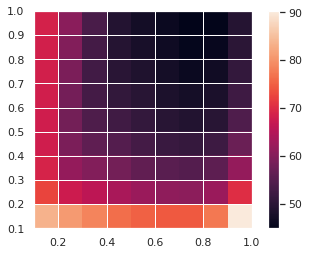

In [119]:
plt.imshow(err, extent=[0.1, 1, 0.1, 1], origin='lower')
plt.colorbar();

In [33]:
np.save('out/200520_ks_asin_pred15_in002to0.5_res01to1', err)

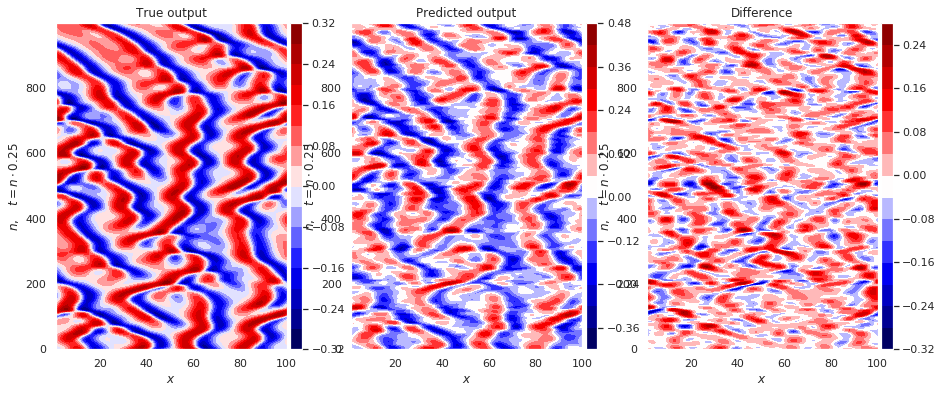

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

N_orig = 2000
N_plot = 1000
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

u_plot = out_test.cpu().numpy()[N_orig:N_orig+N_plot,:]
n, s = np.meshgrid(np.array(range(N))+1, np.arange(N_plot))
plot = axes[0].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = pred_output_test.cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[1].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = (pred_output_test-out_test).cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[2].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

It works okay, and gets better with 5'000 neurons.

# Stability test

In [5]:
input_data = torch.from_numpy(u_train).to(device)
input_len = 100
input_data = input_data[:input_len, :]
# input_data /= np.sqrt(input_data.shape[1])

n_input = 1 # number of time series
input_len, input_dim = input_data.shape # time steps t
# input_dim = 32 #dimension of the time series
input_scale = 0.1  # variance of input
res_scale = 0.7 # variance of reservoir

n_res = 1000
torch.manual_seed(1)
initial_state1 = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf', leak_rate=1)
X1 = model.forward(input_data, initial_state=initial_state1).to(device)

torch.manual_seed(2)
initial_state2 = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf', leak_rate=1)
X2 = model.forward(input_data, initial_state=initial_state2).to(device)

torch.Size([100, 1000])


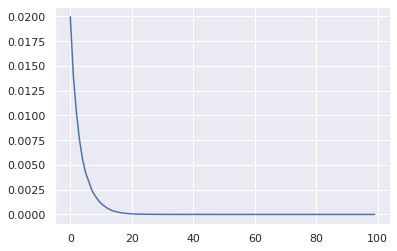

In [6]:
diff = X2 - X1
print(diff.shape)
plt.plot(torch.mean(torch.abs(diff), axis=1).cpu())

We will thus take 100 steps to initialize our recursive kernels (so that they don't depend on the initial state).

# Recurrent kernel computation

In [84]:
train_gram_size = 10000
input_data = torch.from_numpy(u_train).to(device)
input_data = input_data[:train_gram_size, :]

length_of_interest = 40
input_len, input_dim = input_data.shape # time steps t
n_input = input_len - length_of_interest
input_len = length_of_interest

gram_input = torch.zeros(n_input, input_len, input_dim).to(device)
for i_in in range(n_input):
    gram_input[i_in, :, :] = input_data[i_in:i_in+input_len, :]
print(gram_input.shape)
print(gram_input[:2, :5, 0])

torch.Size([9960, 40, 100])
tensor([[-0.1755, -0.1700, -0.1649, -0.1607, -0.1578],
        [-0.1700, -0.1649, -0.1607, -0.1578, -0.1562]], device='cuda:0')


In [44]:
RK = RecKernel(function='arcsin', memory_efficient=False, res_scale=0.7, input_scale=0.1)
K = RK.forward(gram_input)
print(K.shape)

torch.Size([9960, 9960])


In [85]:
RK = RecKernel(function='arcsin', memory_efficient=True, n_iter=40, res_scale=0.7, input_scale=0.1)
K = RK.forward(input_data)
print(K.shape)

torch.Size([9960, 9960])


In [88]:
u_train_t.shape

torch.Size([10000, 100])

In [46]:
pred_horizon = 5

out_train = torch.roll(input_data, -pred_horizon, dims=0)
out_train = out_train[length_of_interest:, :]
print(out_train.shape)

torch.Size([9960, 100])


In [92]:
pred_horizon_range = 100
out_train = torch.zeros(n_input, input_dim * pred_horizon_range).to(device)
out_test = torch.zeros(n_input, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(
        u_train_t[length_of_interest:, :], -pred_horizon, dims=0)
    out_test[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(
        u_test_t[length_of_interest:, :], -pred_horizon, dims=0)

In [113]:
from sklearn.linear_model import Ridge
clf = Ridge(fit_intercept=False, alpha=1e-5)
clf.fit(K.cpu().numpy(), out_train.cpu().numpy())
output_w = torch.from_numpy(clf.coef_.T).to(device)
print(output_w.shape)

pred_output = K @ output_w

torch.Size([9960, 10000])


In [27]:
test_gram_size = 3000
input_data = torch.from_numpy(u_test).to(device)
input_data = input_data[:test_gram_size, :]
n_input = test_gram_size - length_of_interest
pred_horizon = 5

out_test = torch.roll(input_data, -pred_horizon, dims=0)
out_test = out_test[length_of_interest:, :]

gram_input_test = torch.zeros(n_input, input_len, input_dim).to(device)
for i_in in range(n_input):
    gram_input_test[i_in, :, :] = input_data[i_in:i_in+input_len, :]

RK = RecKernel(function='arcsin', memory_efficient=False, res_scale=0.7, input_scale=0.1)
K_test = RK.forward_test(gram_input, gram_input_test)
print(K_test.shape)

pred_output_test = K_test @ output_w
print(pred_output_test.shape)

torch.Size([2960, 9960])
torch.Size([2960, 100])


In [110]:
test_gram_size = 10000
input_data_test = torch.from_numpy(u_test).to(device)
input_data_test = input_data_test[:test_gram_size, :]

RK = RecKernel(function='arcsin', memory_efficient=True, res_scale=0.7, input_scale=0.1, n_iter=length_of_interest)
K_test = RK.forward_test(input_data, input_data_test)
print(K_test.shape)

pred_output_test = K_test @ output_w
print(pred_output_test.shape)

torch.Size([9960, 9960])
torch.Size([9960, 9960])
torch.Size([9960, 10000])


In [98]:
origin = 2000
out_plot = torch.zeros(pred_horizon_range, input_dim)
pred_plot = torch.zeros(pred_horizon_range, input_dim)

for pred_horizon in range(pred_horizon_range):
    out_plot[pred_horizon, :] = out_test[origin, pred_horizon*input_dim:(pred_horizon+1)*input_dim]
    pred_plot[pred_horizon, :] = pred_output_test[origin, pred_horizon*input_dim:(pred_horizon+1)*input_dim]

In [111]:
mse = torch.zeros(pred_horizon_range)

for i in range(pred_horizon_range):
    mse[i] = torch.mean(
        (out_test[:, i*input_dim:(i+1)*input_dim]
        - pred_output_test[:, i*input_dim:(i+1)*input_dim])**2
        )

# mse = torch.mean((out_plot-pred_plot)**2, dim=1)
print(mse.shape)

torch.Size([100])


In [112]:
np.save('out/200522_ksmse_rk_pred100_in01res07', mse)

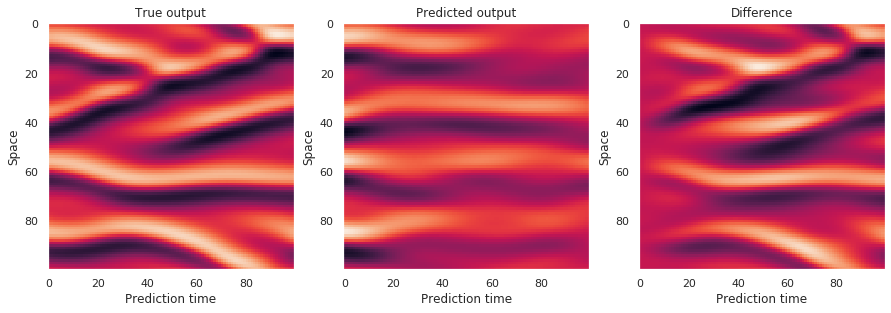

In [99]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

plot = axes[0].imshow(out_plot.T)
# axes[0].axis("off")
axes[0].grid(b=None)
axes[0].set_xlabel("Prediction time")
axes[0].set_ylabel("Space")
axes[0].set_title("True output")
# divider = make_axes_locatable(axes[0])
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(plot, cax=cax)

plot = axes[1].imshow(pred_plot.T)
# axes[1].axis("off")
axes[1].grid(b=None)
axes[1].set_xlabel("Prediction time")
axes[1].set_ylabel("Space")
axes[1].set_title("Predicted output")
# divider = make_axes_locatable(axes[1])
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(plot, cax=cax)

plot = axes[2].imshow((out_plot-pred_plot).T)
# axes[2].axis("off")
axes[2].grid(b=None)
axes[2].set_xlabel("Prediction time")
axes[2].set_ylabel("Space")
axes[2].set_title("Difference");
# divider = make_axes_locatable(axes[2])
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(plot, cax=cax);

In [49]:
test_gram_size = 10000
input_data_test = torch.from_numpy(u_test).to(device)
input_data_test = input_data_test[:test_gram_size, :]
pred_horizon = 5

out_test = torch.roll(input_data_test, -pred_horizon, dims=0)
out_test = out_test[length_of_interest:, :]

RK = RecKernel(function='arcsin', memory_efficient=True, res_scale=0.7, input_scale=0.1, n_iter=length_of_interest)
K_test = RK.forward_test(input_data, input_data_test)
print(K_test.shape)

pred_output_test = K_test @ output_w
print(pred_output_test.shape)

torch.Size([2960, 9960])
torch.Size([2960, 9960])
torch.Size([2960, 100])


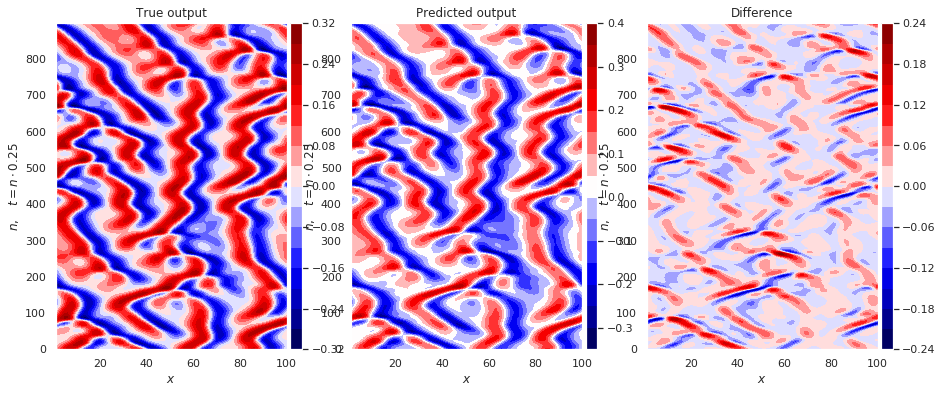

In [50]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

N_orig = 2000
N_plot = 900
_, axes  = plt.subplots(1, 3, figsize=(15, 6))

u_plot = out_test.cpu().numpy()[N_orig:N_orig+N_plot,:]
n, s = np.meshgrid(np.array(range(N))+1, np.arange(N_plot))
plot = axes[0].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[0].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[0].set_title("True output")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = pred_output_test.cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[1].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[1].set_title("Predicted output")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)

u_plot = (pred_output_test-out_test).cpu().numpy()[N_orig:N_orig+N_plot,:]
plot = axes[2].contourf(n, s, u_plot, 15, cmap=plt.get_cmap("seismic"))
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$n, \quad t=n \cdot {:}$".format(dt))
axes[2].set_title("Difference")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plot, cax=cax)